In [1]:
from datetime import datetime

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GAE
from tqdm import trange

from datasets.SP100Stocks import SP100Stocks
from notebooks.models import GCN

# Stocks clustering
The goal of this task is to cluster stocks based on their historical prices and the graph structure.

## Loading the data
The data from the custom PyG dataset for containing the historical prices and the graph structure of the stocks is loaded.

In [108]:
seq_len = 25
dataset = SP100Stocks(past_window=seq_len)
dataset, dataset[0]

(SP100Stocks(1209),
 Data(x=[100, 5, 25], edge_index=[2, 524], y=[100, 1], edge_weight=[524], close_price=[100, 25], close_price_y=[100, 1]))

In [109]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

## Temporal Convolutional Graph Autoencoder

In [4]:
class TCAutoencoder(nn.Module):
	"""
	Temporal convolutional autoencoder for temporal graph autoencoder.
	"""
	def __init__(self, in_channels: int, latent_dim: int, seq_len: int = 25):
		super(TCAutoencoder, self).__init__()
		self.seq_len = seq_len
		self.encoder = nn.Sequential(
			nn.Conv1d(in_channels, latent_dim, 5, stride=3),
			nn.ReLU(),
			nn.Conv1d(latent_dim, latent_dim, 5, stride=3),
		)
		self.decoder = nn.Sequential(
			nn.ConvTranspose1d(latent_dim, latent_dim, 5, stride=2),
			nn.ReLU(),
			nn.ConvTranspose1d(latent_dim, latent_dim, 5, stride=2, padding=1),
			nn.ReLU(),
			nn.ConvTranspose1d(latent_dim, in_channels, 5, stride=2),
		)
		
	def encode(self, x: torch.tensor) -> torch.tensor:
		return self.encoder(x).squeeze(-1)
			
	def decode(self, z: torch.tensor) -> torch.tensor:
		return self.decoder(z.unsqueeze(-1))
			
	def loss(self, x: torch.tensor, z: torch.tensor) -> torch.tensor:
		return F.mse_loss(self.decode(z), x)
	
	def forward(self, x: torch.tensor) -> torch.tensor:
		return self.encode(x)

In [5]:
class TCGAE(nn.Module):
	def __init__(self, in_channels: int, latent_dim: int, seq_len: int = 25):
		super(TCGAE, self).__init__()
		self.seq_len = seq_len
		self.hidden_dim = latent_dim // 2
		self.latent_dim = latent_dim
		self.gae = GAE(
			GCN(in_channels, [self.hidden_dim, self.hidden_dim]),
		)
		self.tcae = TCAutoencoder(self.hidden_dim, latent_dim, seq_len)
			
	def loss(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		recon_loss = 0
		latent_seq = torch.zeros(x.shape[0], self.hidden_dim, self.seq_len)
		for i in range(self.seq_len):
			latent_seq[:, :, i] = self.gae.encode(x[:, :, i], edge_index, edge_weight)
			recon_loss += self.gae.recon_loss(latent_seq[:, :, i], edge_index,)
		return self.tcae.loss(latent_seq, self.tcae(latent_seq)) + recon_loss / self.seq_len
			
	def encode(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		latent_seq = torch.zeros(x.shape[0], self.hidden_dim, self.seq_len)
		for i in range(self.seq_len):
			latent_seq[:, :, i] = self.gae.encode(x[:, :, i], edge_index, edge_weight)
		return self.tcae(latent_seq)
	
	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		return self.encode(x, edge_index, edge_weight)

In [6]:
in_channels, latent_dim = dataset[0].x.shape[1], 8
lr, num_epochs = 0.01, 1

model = TCGAE(in_channels, latent_dim, seq_len)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [7]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader, epochs: int):
	writer = SummaryWriter(f'runs/StocksClustering_{datetime.now().strftime("%d_%m_%Hh%M")}_{model.__class__.__name__}')
	for epoch in (pbar := trange(epochs, desc='Epochs')):
		for i, data in enumerate(dataloader):
			optimizer.zero_grad()
			loss = model.loss(data.x, data.edge_index, data.edge_weight)
			loss.backward()
			optimizer.step()
			pbar.set_postfix({'Loss': loss.item(), 'Batch': f"{100*(i+1)/len(dataloader):.2f}%"})
			writer.add_scalar('Loss/Reconstruction Loss', loss.item(), epoch * len(dataloader) + i)

In [8]:
train(model, optimizer, dataloader, num_epochs)

Epochs: 100%|██████████| 1/1 [06:43<00:00, 403.73s/it, Loss=1.36, Batch=100.00%]


In [11]:
model(dataset[0].x, dataset[0].edge_index, dataset[0].edge_weight).shape

torch.Size([100, 4, 25])

In [13]:
model.tcae(model(dataset[0].x, dataset[0].edge_index, dataset[0].edge_weight)).shape

torch.Size([100, 8])

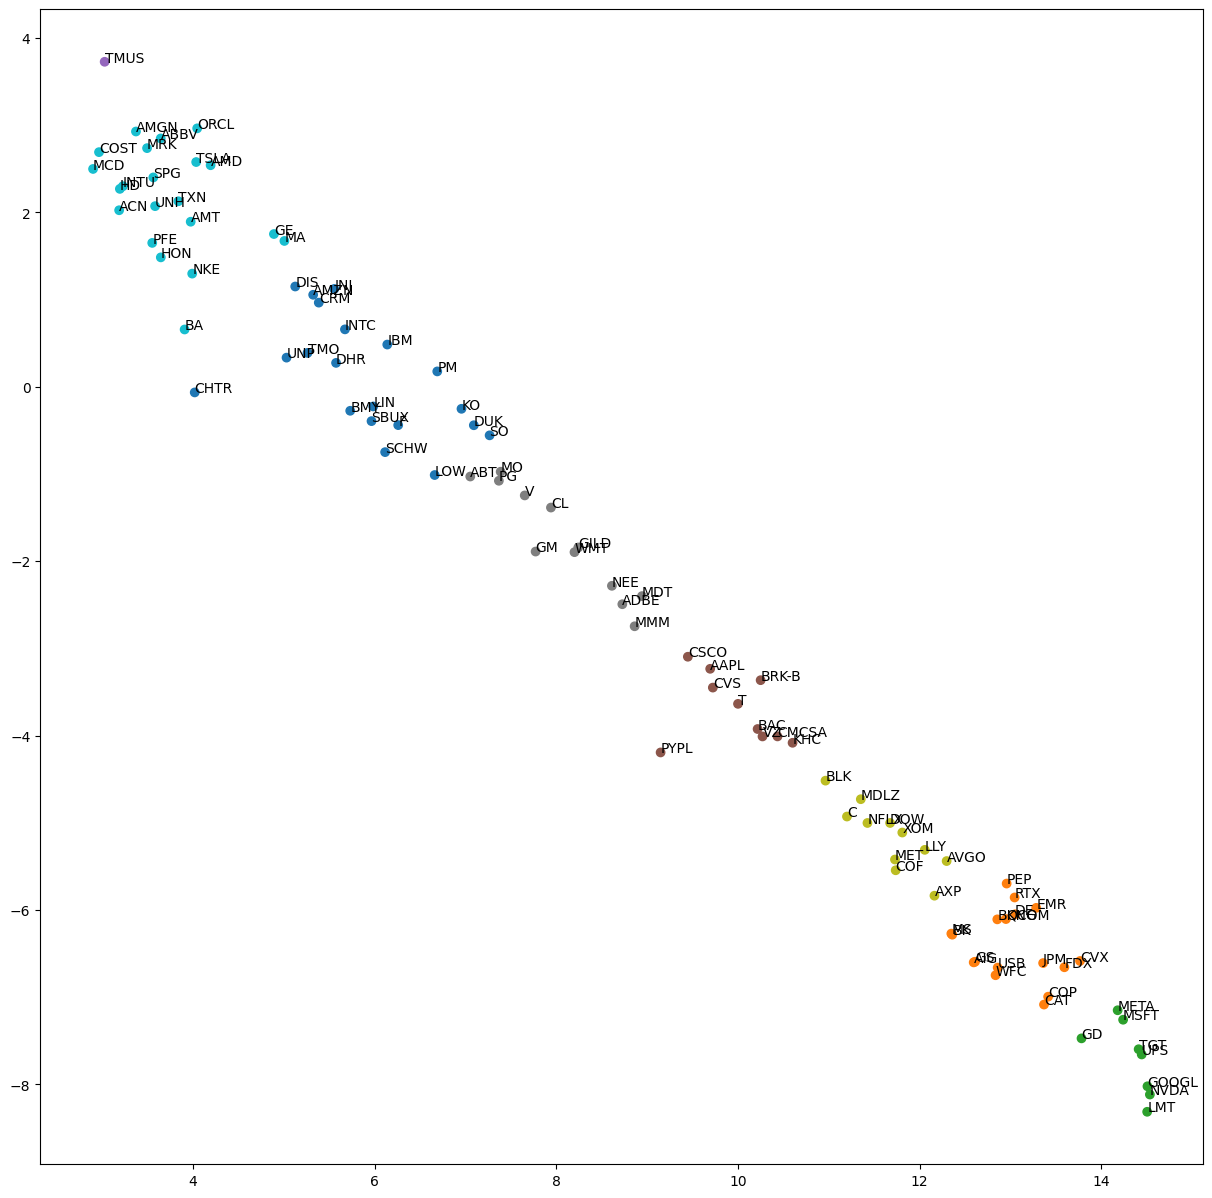

In [121]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from datasets.utils import get_stocks_labels

data = dataset[-1]

n_clusters = 8

z = model.tcae(model(data.x, data.edge_index, data.edge_weight))

z = z.detach().numpy().reshape(-1, latent_dim)
labels = get_stocks_labels()

z_embedded = TSNE(n_components=2).fit_transform(z)
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(z)

plt.figure(figsize=(15, 15))
plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=kmeans.labels_, cmap='tab10')
for i, label in enumerate(labels):
	plt.annotate(label, (z_embedded[i, 0], z_embedded[i, 1]))
plt.show()

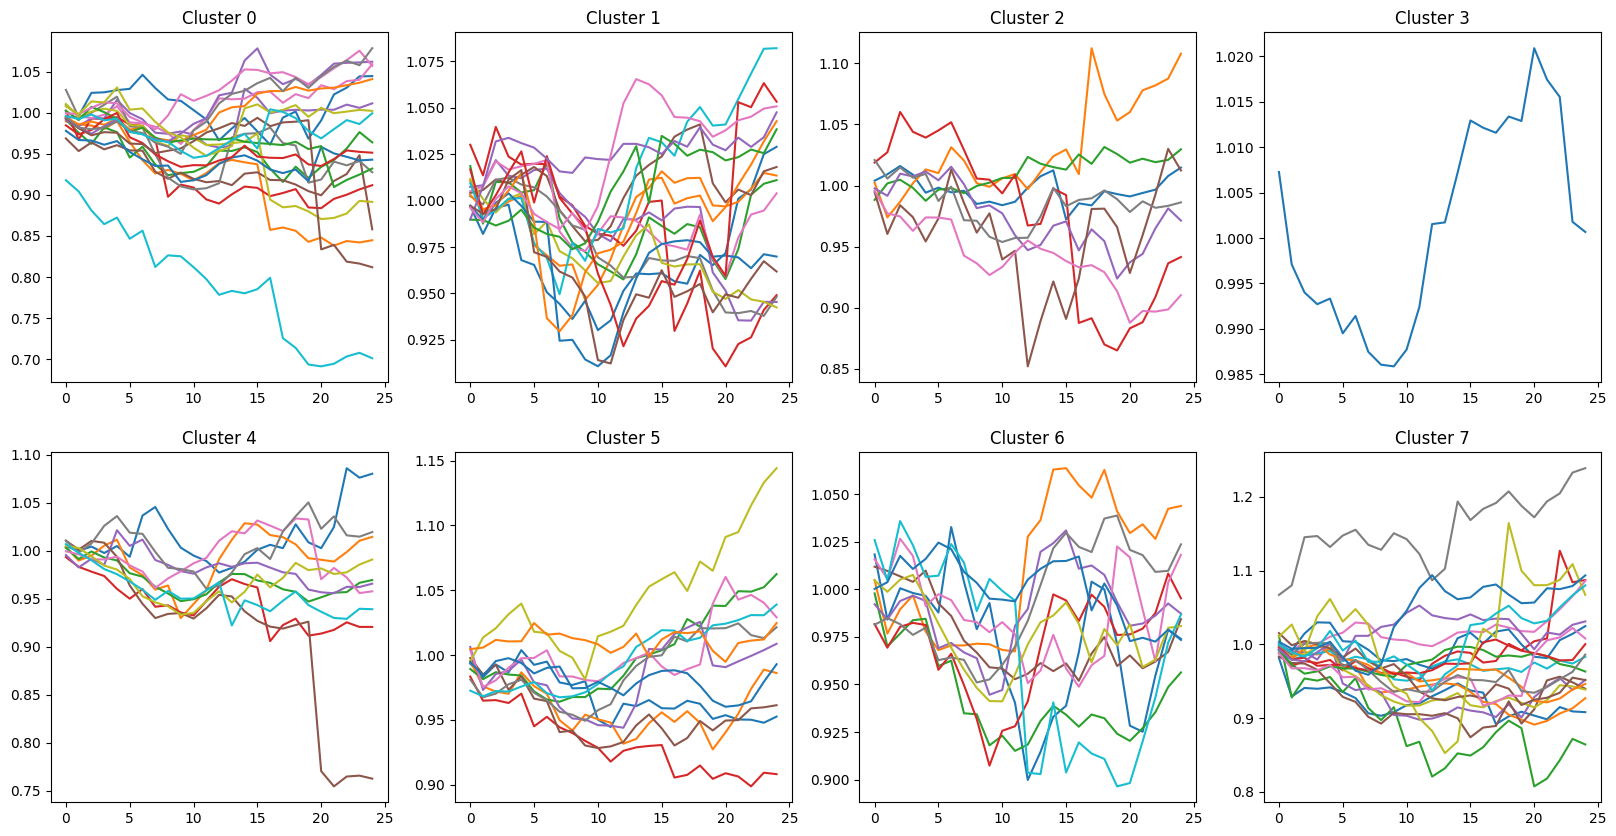

In [122]:
import numpy as np

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(n_clusters):
	ax = axs[i//4, i%4]
	ax.set_title(f'Cluster {i}')
	for j in np.where(kmeans.labels_ == i)[0]:
		variations = np.cumprod(1 + data.x[j, 2, :].detach().numpy() / 100, axis=0)
		ax.plot(variations)
		# ax.set_yscale('log')
plt.show()

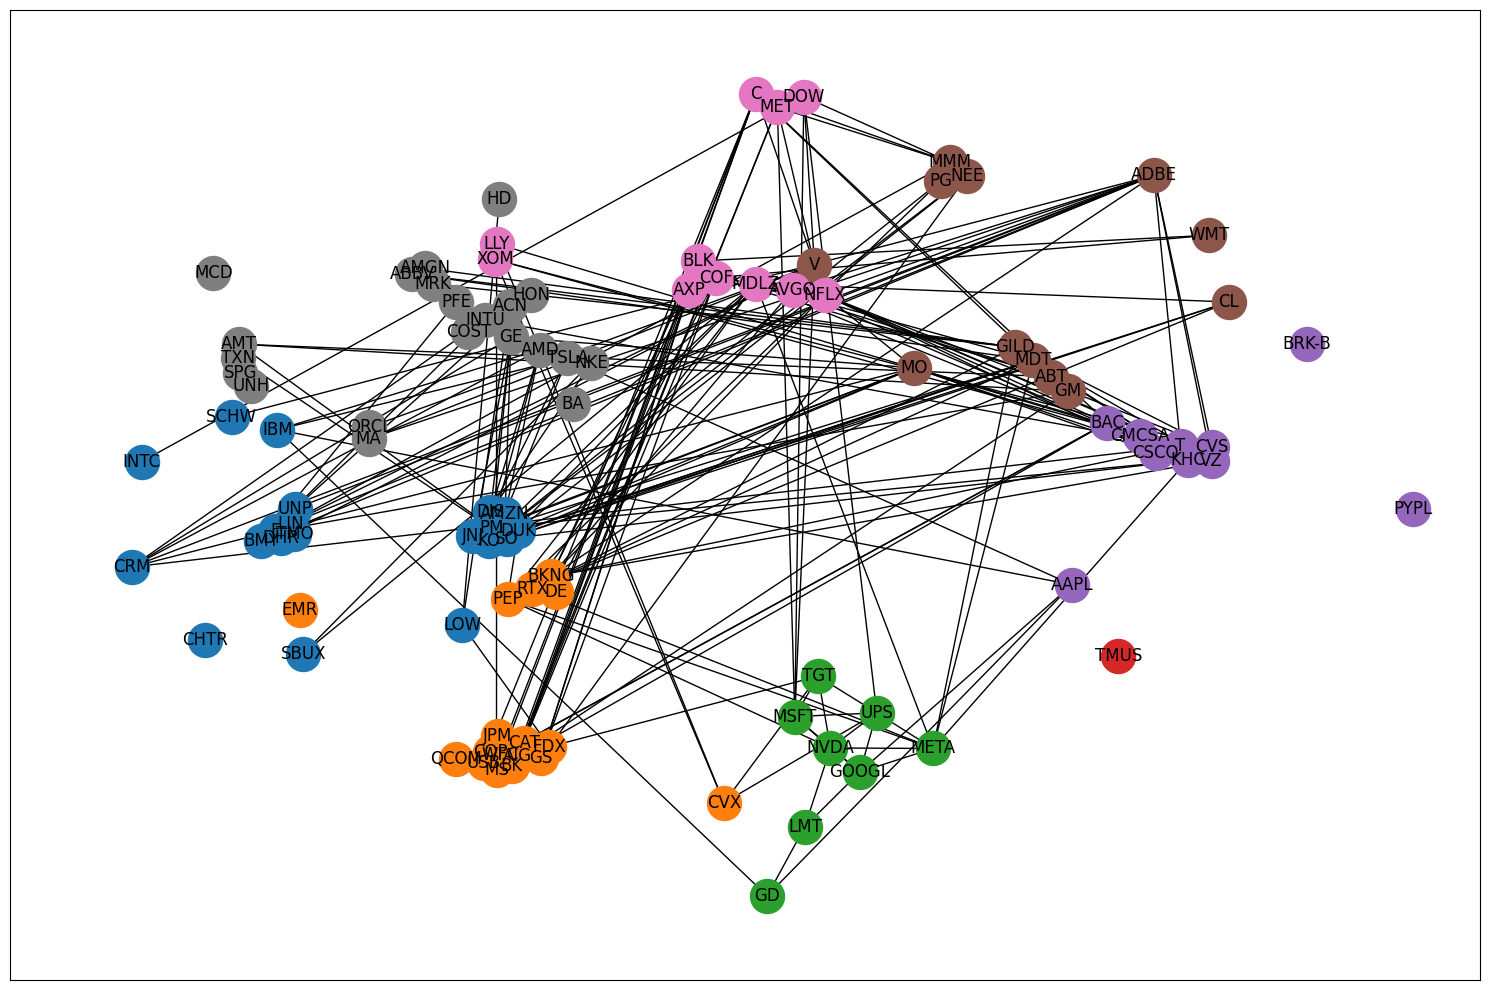

In [124]:
import matplotlib.pyplot as plt
from torch_geometric.utils import to_dense_adj
import networkx as nx
adj = to_dense_adj(data.edge_index)[0].detach().numpy()

plt.figure(figsize=(15, 10))
G = nx.from_numpy_array(adj)
G = nx.relabel_nodes(G, {i: label for i, label in enumerate(labels)})

clusters = [np.where(kmeans.labels_ == i)[0] for i in range(n_clusters)]
communities = [
	set(
		label for stock_idx, label in enumerate(labels) if stock_idx in cluster
	) for cluster in clusters
]

# Compute positions for the node clusters as if they were themselves nodes in a
# supergraph using a larger scale factor
supergraph = nx.cycle_graph(len(communities))
superpos = nx.spring_layout(supergraph, scale=20)

# Use the "supernode" positions as the center of each node cluster
centers = list(superpos.values())
pos = {}
for center, comm in zip(centers, communities):
    pos.update(nx.spring_layout(nx.subgraph(G, comm), center=center, scale=10))

# Nodes colored by cluster
for nodes, clr in zip(communities, (f"C{i}" for i in range(len(communities)))):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes, node_color=clr, node_size=600, label=True)

nx.draw_networkx_labels(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos)

plt.tight_layout()
plt.show()